# [실습] Ollama과 vLLM을 이용한 Agentic Work 만들기   



## 라이브러리 설치


이번 실습은 무료 코랩(T4 GPU)이 아닌 고성능 GPU 라이브러리에서 진행합니다.   
무료 코랩으로 진행하시는 경우, GPU 성능의 한계로 vLLM 실행이 어렵습니다.

<br><br>


In [ ]:
!pip install transformers bitsandbytes openai langchain_openai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 426.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 176.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 351.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 348.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.1/294.1 MB 166.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 347.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 219.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 423.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45

In [ ]:
!pip install langchain_experimental langgraph langchain langchain_community langchain_huggingface dotenv -q


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
# Pytorch 버전 호환
# vllm 0.10 : Pytorch 2.7.1
# vllm 0.9.x == 2.7.0
# vllm 0.8.x == 2.6.0
# vllm 0.6.x == 2.5.1

!pip install pyzmq flashinfer-python==0.2.10 vllm==0.10.1 -q
!pip install  flashinfer-python pyzmq vllm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.4/862.4 kB 193.9 MB/s eta 0:00:00
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 24.0.1
    Uninstalling pyzmq-24.0.1:
      Successfully uninstalled pyzmq-24.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.5.5 requires pyzmq<25,>=17, but you have pyzmq 26.4.0 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


설치 후에는 세션을 재시작해 주세요.

In [ ]:
# Flash Attention: 리눅스 전용 설치방법
# Windows 설치는 https://github.com/kingbri1/flash-attention/releases 참고
!pip install flash-attn --no-build-isolation -q



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


설치할 라이브러리가 많으므로, 가급적 설치 후 세션 재시작을 수행해 주세요.

vLLM은 캐싱을 통해 효과적인 추론과 동시 실행을 지원합니다.   
아래 코드를 터미널에서 실행하세요.

```
vllm serve unsloth/gemma-3-12b-it-bnb-4bit --dtype auto --max_model_len 32768 --quantization bitsandbytes --served_model_name gemma3 --max_num_seqs 1
```

어느 정도 시간이 지나면, vLLM 서빙이 완료됩니다.   
vllm Serve가 정상적으로 완료되면, 8000번 포트에서 모델을 확인하실 수 있습니다.

In [ ]:
# 모델 주소 확인
!curl http://0.0.0.0:8000/v1/models

In [ ]:
from langchain_openai import ChatOpenAI, OpenAI

llm = ChatOpenAI(
    base_url="http://localhost:8000/v1",
    api_key="token-abc123",
    model="gemma3",
    temperature=0.5,
    max_tokens=1024
)

In [ ]:
for s in llm.stream("vLLM이 뭐야?"):
    print(s.content, end='')

vLLM은 **고성능 LLM(Large Language Model) 추론을 위한 오픈소스 엔진**입니다. 쉽게 말해, LLM을 더 빠르고 효율적으로 실행할 수 있도록 도와주는 도구라고 생각하시면 됩니다.

**vLLM의 주요 특징 및 장점:**

*   **PagedAttention:** vLLM의 핵심 기술입니다. LLM 추론 시 메모리 사용량을 크게 줄여줍니다. LLM은 텍스트를 처리하면서 중간 결과를 메모리에 저장해야 하는데, PagedAttention은 이 과정을 효율적으로 관리하여 더 많은 요청을 동시에 처리할 수 있도록 합니다. 마치 컴퓨터의 가상 메모리처럼, 필요한 만큼만 메모리를 할당하고 관리하는 방식입니다.
*   **빠른 추론 속도:** PagedAttention 덕분에 기존 LLM 추론 엔진보다 훨씬 빠른 속도로 LLM을 실행할 수 있습니다.
*   **높은 처리량:** 더 많은 요청을 동시에 처리할 수 있어, LLM 서비스를 운영할 때 비용 효율성을 높일 수 있습니다.
*   **다양한 LLM 지원:** Llama 2, Mistral, Falcon 등 다양한 LLM을 지원합니다.
*   **쉬운 사용법:** API를 통해 쉽게 통합할 수 있으며, Hugging Face Transformers와 호환됩니다.

**vLLM이 왜 중요할까요?**

LLM은 많은 연산 자원을 필요로 하며, 특히 추론(inference) 과정에서 많은 메모리를 사용합니다. vLLM은 이러한 문제를 해결하여 LLM을 더 많은 사람들이 더 쉽게 사용할 수 있도록 합니다. LLM 서비스를 운영하는 기업에게는 비용 절감과 성능 향상이라는 이점을 제공합니다.

**vLLM에 대해 더 자세히 알아보고 싶다면:**

*   **vLLM 공식 웹사이트:** [https://vllm.ai/](https://vllm.ai/)
*   **GitHub 저장소:** [https://github.com/vllm-project/vllm](https://github.com/vllm-proje

In [ ]:
def convert_chat(messages, add_generation_prompt = True):
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=add_generation_prompt)

example = [{'role':'user', 'content':'안녕'}]
convert_chat(example)

'<bos><start_of_turn>user\n안녕<end_of_turn>\n<start_of_turn>model\n'

## 2. HuggingFace LLM과 툴 연동하기

먼저 툴을 설정합니다.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonREPLTool
from datetime import datetime

tavily_search = TavilySearchResults(
    max_results=3)

repl_tool = PythonREPLTool()
repl_tool.invoke("for i in range(10): print(i)")


@tool
def current_date() -> str:
    "현재 날짜를 %y-%m-%d 형식으로 반환합니다."
    return datetime.now().strftime("%Y-%m-%d")



tools = [tavily_search, repl_tool, current_date]


Python REPL can execute arbitrary code. Use with caution.


vLLM에서는 Tool Binding을 수행하려면   
--enable-auto-tool-choice 를 추가한 뒤, 전용 파서를 연결해야 합니다.   
Llama, Qwen, Hermes 등의 모델이 가능합니다.   
https://docs.vllm.ai/en/stable/features/tool_calling.htm

In [ ]:
from langchain_core.utils.function_calling import convert_to_openai_tool


convert_to_openai_tool(tools[2])


{'type': 'function',
 'function': {'name': 'current_date',
  'description': '현재 날짜를 %y-%m-%d 형식으로 반환합니다.',
  'parameters': {'properties': {}, 'type': 'object'}}}

툴 설명이 담긴 문자열을 구성합니다.

In [ ]:
tool_desc = str('\n---\n'.join([str(convert_to_openai_tool(tool)) for tool in tools]))
print(tool_desc)

{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}
---
{'type': 'function', 'function': {'name': 'Python_REPL', 'description': 'A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}
---
{'type': 'function', 'function': {'name': 'current_date', 'description': '현재 날짜를 %y-%m-%d 형식으로 반환합니다.', 'parameters': {'properties': {}, 'type': 'object'}}}


시스템 프롬프트를 구성합니다.   
성능에 매우 중요한 영향을 미치므로, 영어로 작성했습니다.

In [ ]:
system_prompt = f'''
You are a helpful assistant with tools below.
You can decide whether to invoke any functions or not.
If you decide to use any of tools.
print name and required parameters of the tool within a json blob correctly.
For python code, Return the object as a raw dictionary, without escaping quotes or newlines.

for tool use: wrap your output within ```tool_code```.

Example:
```tool_code
{{"name":'name of tool', "arguments":{{List of apparent argument and parameters}}}}
```

When the output of the tool is provided, it will be wrapped within ``tool_output```
Answer accordingly from the result of the tool output.

The question might need some sequential, multiple tool execution.
Think Step by Step.

The following tools are available:
{tool_desc}'''

시스템 프롬프트에 들어가야 하는 내용은 다음과 같습니다.
- Tool Format
- Tool Call Format
- Tool Result Format

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage


messages = [SystemMessage(system_prompt),
            HumanMessage('오늘 날짜가 며칠이니?')]


In [ ]:
response = llm.invoke(messages)
messages.append(response)
response


AIMessage(content='```tool_code\n{"name": "current_date", "arguments": {}}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 436, 'total_tokens': 457, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma3', 'system_fingerprint': None, 'id': 'chatcmpl-a25d13c9f0ea437cb82dd75e1b46e70c', 'finish_reason': 'stop', 'logprobs': None}, id='run-42102c77-bc44-4e88-9c7e-6f894df8067c-0', usage_metadata={'input_tokens': 436, 'output_tokens': 21, 'total_tokens': 457, 'input_token_details': {}, 'output_token_details': {}})

In [ ]:
print(response.content)

```tool_code
{"name": "current_date", "arguments": {}}
```


tool_code를 받았으니, 해당 내용을 파싱합니다.

In [ ]:
import ast


def parse_tool(text):
    try:
        text = text.split('```tool_code\n')[1].split('\n```')[0]
        # tool_code로 wrap된 중간 코드 추출

        parsed = ast.literal_eval(text)
        # Dict 형태의 값 변환 (json load와 유사)

        name = parsed.get('name')
        arguments = parsed.get('arguments', {})
        # name과 argument return
        return {'name':name, 'arguments':arguments}
    except (ValueError, SyntaxError):
        return None

result = parse_tool(response.content)
name,arguments = result['name'], result['arguments']
name, arguments

('current_date', {})

툴 실행을 연결합니다.

In [ ]:
# 툴 이름과 툴 연결
tool_dict = {tool.name: tool for tool in tools}

def execute_tool(name, arguments):
    # 툴 실행한 뒤 tool_output으로 wrap
    result = f'''```tool_output
{tool_dict[name].invoke(arguments)}
```'''
    return result

tool_result = execute_tool(**parse_tool(response.content))

print(tool_result)

```tool_output
2025-04-15
```


In [ ]:
messages.append(HumanMessage(tool_result))
messages[1:]
# 질문 + Tool 요청 + Tool 결과

[HumanMessage(content='오늘 날짜가 며칠이니?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='```tool_code\n{"name": "current_date", "arguments": {}}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 436, 'total_tokens': 457, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma3', 'system_fingerprint': None, 'id': 'chatcmpl-a25d13c9f0ea437cb82dd75e1b46e70c', 'finish_reason': 'stop', 'logprobs': None}, id='run-42102c77-bc44-4e88-9c7e-6f894df8067c-0', usage_metadata={'input_tokens': 436, 'output_tokens': 21, 'total_tokens': 457, 'input_token_details': {}, 'output_token_details': {}}),
 HumanMessage(content='```tool_output\n2025-04-15\n```', additional_kwargs={}, response_metadata={})]

In [ ]:
# 결과 해석
response = llm.invoke(messages)
response

AIMessage(content='오늘 날짜는 2025년 4월 15일입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 483, 'total_tokens': 503, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma3', 'system_fingerprint': None, 'id': 'chatcmpl-2ea92a48c466474d95f92496514bbb88', 'finish_reason': 'stop', 'logprobs': None}, id='run-f2417c07-718e-4a31-a8d2-aec6ce066b08-0', usage_metadata={'input_tokens': 483, 'output_tokens': 20, 'total_tokens': 503, 'input_token_details': {}, 'output_token_details': {}})

In [ ]:
messages = [SystemMessage(system_prompt),
            HumanMessage('2025년 4월 발표된 GPT-4.1 모델이 어떤 모델이야? 한국어로 설명해줘.')]
response = llm.invoke(messages)
messages.append(response)
response

AIMessage(content='2025년 4월에 발표된 GPT-4.1 모델에 대한 정보를 찾기 위해 검색을 수행하겠습니다.\n\n```tool_code\n{"name": "tavily_search_results_json", "arguments": {"query": "2025년 4월 GPT-4.1 모델"}}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 454, 'total_tokens': 527, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma3', 'system_fingerprint': None, 'id': 'chatcmpl-1a93a67679514213bf8ea2dc6f860ac7', 'finish_reason': 'stop', 'logprobs': None}, id='run-3b356dfd-b74c-4f7a-ae65-61cf75a60530-0', usage_metadata={'input_tokens': 454, 'output_tokens': 73, 'total_tokens': 527, 'input_token_details': {}, 'output_token_details': {}})

In [ ]:
print(response.content)

2025년 4월에 발표된 GPT-4.1 모델에 대한 정보를 찾기 위해 검색을 수행하겠습니다.

```tool_code
{"name": "tavily_search_results_json", "arguments": {"query": "2025년 4월 GPT-4.1 모델"}}
```


In [ ]:
tool_result = execute_tool(**parse_tool(response.content))
tool_result

'```tool_output\n[{\'title\': "오픈AI의 새로운 진화, \'GPT-4.1\'과 온디바이스 시대의 서막", \'url\': \'https://m.blog.naver.com/uripeoyn_/223830042974?recommendCode=2&recommendTrackingCode=2\', \'content\': \'블로그\\n\\n카테고리 이동\\n\\n\\n\\n\\n1200만 시니어 AI 교육1인자 가장 쉬운 인공지능 강의\\n\\n오픈AI의 새로운 진화, ‘GPT-4.1’과 온디바이스 시대의 서막 – 경량화 ‘o4-미니’, ‘나노’, 그리고 ‘o3’ 모델까지 동시 출격 예고\\n\\n2025. 4. 11. 19:36\\n\\n2025년 4월, AI 기술의 진화는 다시 한 번 중요한 분기점을 맞이하고 있습니다. 바로 오픈AI(OpenAI)가 GPT-4o의 상위 버전으로 추정되는 **‘GPT-4.1’**과 ‘o4-미니(Mini)’, ‘나노(Nano)’, 그리고 ‘o3’ 모델까지 다음 주 공개를 예고하면서입니다.\\n\\n\\u200b\\n\\n\\u200b\\n\\n이 새로운 라인업은 단순한 업그레이드가 아닌, AI 모델의 경량화와 온디바이스(기기 내 탑재) 실행을 가능하게 하는 본격적인 이정표가 될 전망입니다.\\n\\n\\u200b\\n\\n1. GPT-4.1 – 더 강력한 멀티모달, 더 똑똑한 AVM 엔진\\n\\n\\u200b [...] GPT-4o는 오픈AI가 2024년 처음 선보였던 플래그십 멀티모달 모델로, 텍스트, 이미지, 오디오를 통합 처리하며 실시간 상호작용이 가능한 고성능 AI였습니다. 특히 ChatGPT의 **‘고급 음성 모드(Advanced Voice Mode, AVM)’**의 핵심 엔진으로 주목받았습니다.\\n\\n\\u200b\\n\\n이번에 예고된 GPT-4.1은 그 GPT-4o의 성능 향상 버전으로, 더 빠른 응답, 개선된 논리적 추론, 안정적인 멀티모달 연산을 목표로 설계된 것으로 알려졌습니다.\\n\\

In [ ]:
messages[-1]

AIMessage(content='2025년 4월에 발표된 GPT-4.1 모델에 대한 정보를 찾기 위해 검색을 수행하겠습니다.\n\n```tool_code\n{"name": "tavily_search_results_json", "arguments": {"query": "2025년 4월 GPT-4.1 모델"}}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 454, 'total_tokens': 527, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma3', 'system_fingerprint': None, 'id': 'chatcmpl-1a93a67679514213bf8ea2dc6f860ac7', 'finish_reason': 'stop', 'logprobs': None}, id='run-3b356dfd-b74c-4f7a-ae65-61cf75a60530-0', usage_metadata={'input_tokens': 454, 'output_tokens': 73, 'total_tokens': 527, 'input_token_details': {}, 'output_token_details': {}})

In [ ]:
messages.append(HumanMessage(tool_result))
response = llm.invoke(messages)
response

AIMessage(content="GPT-4.1은 2025년 4월에 발표된 GPT-4o의 상위 버전으로 추정되는 모델입니다. 오픈AI는 GPT-4.1과 함께 'o4-미니', '나노', 'o3' 모델도 공개했습니다.\n\nGPT-4.1은 더 강력한 멀티모달 기능, 빠른 응답 속도, 개선된 논리적 추론 능력을 갖추고 있습니다. 특히, '나노' 모델은 오픈AI 최초의 경량형 LLM으로, 기기 내에서 실행이 가능하여 온디바이스 AI 시대를 예고합니다. 또한, GPT-4.1은 최대 100만 토큰의 문맥을 지원하며, 2024년 6월까지의 지식을 포함하고 있습니다. API를 통해 먼저 출시되었으며, GPT-4.5 Preview를 대체할 예정입니다.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 198, 'prompt_tokens': 2002, 'total_tokens': 2200, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma3', 'system_fingerprint': None, 'id': 'chatcmpl-5ce90a24f23f4cfb9e63e1abded5d423', 'finish_reason': 'stop', 'logprobs': None}, id='run-248c17b2-0db8-4e2e-aee9-14b8fc1da6b5-0', usage_metadata={'input_tokens': 2002, 'output_tokens': 198, 'total_tokens': 2200, 'input_token_details': {}, 'output_token_details': {}})

일반적인 입출력 관계의 툴은 이와 같은 방식으로 간단하게 구성할 수 있습니다.   
(만약, Python_REPL과 같이 argument가 복잡한 툴을 수행하는 경우에는   
별도의 함수로 변환하거나 결과물을 수정하는 작업이 필요할 수 있습니다.)

해당 구현을 통해, ReAct Agent 구조를 만들어 보겠습니다.    
bind_tools가 없기 때문에, 기존의 Tool Message를 사용하기 어렵습니다.

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages : Annotated[list, add_messages]   # 메시지 맥락을 저장하는 리스트


In [ ]:
from langchain_core.messages import ToolMessage

tool_list = {tool.name: tool for tool in tools}
# tool 목록 dict로 생성

def tool_node(state):
    tool_outputs = []
    tool_call_msgs = state['messages'][-1]
    # 마지막 메시지: 툴 콜링 메시지
    if '```tool_code' in tool_call_msgs.content:
        tool_result = execute_tool(**parse_tool(tool_call_msgs.content))
        # tool 실행 결과 얻기 (결과는 ```tool_output```)
        tool_outputs.append(HumanMessage(tool_result))

    return {'messages': tool_outputs}

def agent(state):
    system_prompt = SystemMessage(f'''
You are a helpful assistant with tools below.
You can decide whether to invoke any functions or not.
If you decide to use any of tools.
print name and required parameters of the tool within a json blob correctly.
For python code, Return the object as a raw dictionary, without escaping quotes or newlines.

for tool use: wrap your output within ```tool_code```.

Example:
```tool_code
{{"name":'name of tool', "arguments":{{List of apparent argument and parameters}}}}
```

When the output of the tool is provided, it will be wrapped within ``tool_output```
Answer accordingly from the result of the tool output.

The question might need some sequential, multiple tool execution.
Think Step by Step.

The following tools are available:
{tool_desc}


Answer in Korean.''')


    response = llm.invoke([system_prompt] + state["messages"])
    return {'messages': response}

def tool_needed(state):

    last_msg = state['messages'][-1]
    if '```tool_code' in last_msg.content: # 툴 콜링이 필요하면
        return "continue"
    else:
        return "finish"

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("agent", agent)
builder.add_node("tools", tool_node)

builder.add_edge(START, 'agent'),
builder.add_conditional_edges("agent",
                              tool_needed,
                               {"continue": "tools","finish": END})
builder.add_edge("tools", "agent")

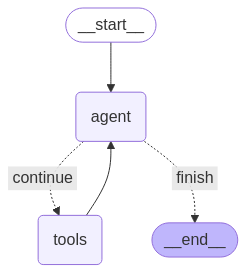

In [ ]:
graph = builder.compile()
graph

In [ ]:
response = graph.invoke({'messages':[HumanMessage(content="오늘 날짜에 태어난 유명인들 조사해서 알려줘.")]})
response

{'messages': [HumanMessage(content='오늘 날짜에 태어난 유명인들 조사해서 알려줘.', additional_kwargs={}, response_metadata={}, id='5e436e3d-4033-4a9d-b1c4-41810f76d617'),
  AIMessage(content='오늘 날짜를 알아야 오늘 날짜에 태어난 유명인을 찾을 수 있습니다. 먼저 `current_date` 도구를 사용하여 오늘 날짜를 알아봅니다.\n```tool_code\n{"name": "current_date", "arguments": {}}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 447, 'total_tokens': 506, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma3', 'system_fingerprint': None, 'id': 'chatcmpl-add7d72a92b74226891bfea8cb997829', 'finish_reason': 'stop', 'logprobs': None}, id='run-21398e0f-c2a0-4c82-9bcf-ca58ec0dfc06-0', usage_metadata={'input_tokens': 447, 'output_tokens': 59, 'total_tokens': 506, 'input_token_details': {}, 'output_token_details': {}}),
  HumanMessage(content='```tool_output\n2025-04-15\n```', additional_kwargs={}, response_metadata={}, id='dc9312c8-3082-414b-91e6-13b7b833d571'),

이번에는 병렬 실행이 가능한 vLLM을 이용해, 리포트 작성 모듈을 구성해 봅시다.

In [ ]:
from typing_extensions import TypedDict, Annotated, Literal, List
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages

from langchain_core.output_parsers import PydanticOutputParser

# 전체 섹션의 구획: Contents (Chapter List)
# Chapter: name, outline
class Chapter(BaseModel):
    name: str = Field(description="챕터의 이름")
    outline: str = Field(description="챕터의 주요 내용, 1문장 길이로")


class Contents(BaseModel):
    contents: List[Chapter] = Field(description="전체 리포트의 섹션 구성")

parser = PydanticOutputParser(pydantic_object=Contents)

format_str = parser.get_format_instructions()

planner = llm | parser

In [ ]:
import torch

with torch.inference_mode():
    example = planner.invoke(f"LLM의 발전 과정에 대한 보고서 구획을 작성해 주세요. \n{format_str}")
example.contents

[Chapter(name='서론: LLM의 등장과 중요성', outline='LLM의 정의, 발전 배경, 사회적 영향 및 본 보고서의 목적을 간략히 소개한다.'),
 Chapter(name='1세대 LLM: 초기 모델과 한계점 (2018-2020)', outline='GPT-1, BERT 등 초기 LLM의 등장 배경, 구조, 성능을 분석하고, 파라미터 규모 제한, 문맥 이해 부족, 생성 품질 저하 등의 한계를 지적한다.'),
 Chapter(name='2세대 LLM: 규모 확장과 Transformer 아키텍처의 발전 (2020-2022)', outline='GPT-2, GPT-3, PaLM 등 파라미터 규모가 급격히 증가하며 성능 향상을 이룬 모델들을 살펴보고, Transformer 아키텍처의 발전이 LLM 성능에 미친 영향을 분석한다.'),
 Chapter(name='3세대 LLM: Instruction Tuning과 강화 학습 (2022-2023)', outline='Instruction Tuning, RLHF (Reinforcement Learning from Human Feedback) 등 인간 피드백을 활용하여 모델 성능을 향상시키는 기법들을 소개하고, ChatGPT, Bard 등 대화형 LLM의 등장과 발전 과정을 설명한다.'),
 Chapter(name='4세대 LLM: 멀티모달, 에이전트, 그리고 미래 (2023-현재)', outline='이미지, 오디오 등 다양한 데이터를 처리하는 멀티모달 LLM, 자율적으로 작업을 수행하는 LLM 에이전트의 등장과 발전 현황을 살펴보고, LLM의 미래 발전 방향과 과제를 제시한다.'),
 Chapter(name='LLM 발전의 기술적 핵심 요소', outline='Transformer 아키텍처, Self-Attention 메커니즘, 대규모 데이터셋, 분산 학습 기술 등 LLM 발전의 핵심 기술 요소들을 상세히 설명한다.'),
 Chapter(name='LLM의 윤리적, 사회적 과제', outline='LLM의

In [ ]:
from langchain.output_parsers import OutputFixingParser

# parse 불가능한 출력이 주어지면, llm을 통해 교정하는 파서
new_parser = OutputFixingParser.from_llm(parser=parser, llm=llm)

planner = llm | new_parser

with torch.inference_mode():
    example = planner.invoke(f"LLM의 발전 과정에 대한 3챕터 구성의 보고서 구획을 작성해 주세요. \n{format_str}")
example.contents

[Chapter(name='1장: LLM의 태동과 초기 발전 (2018-2020)', outline='Transformer 아키텍처의 등장과 GPT-1, BERT와 같은 초기 LLM들이 등장하며 자연어 처리 분야에 혁신을 가져왔다.'),
 Chapter(name='2장: 규모 확장과 발전 (2020-2022)', outline='GPT-2, GPT-3, LaMDA 등 모델 규모가 기하급수적으로 증가하며 few-shot learning 능력이 향상되고, 다양한 task에서 뛰어난 성능을 보였다.'),
 Chapter(name='3장: 최신 동향과 미래 전망 (2022-현재)', outline='Instruction tuning, Reinforcement Learning from Human Feedback (RLHF) 등의 기법을 통해 LLM의 성능과 제어 가능성이 향상되었고, 멀티모달 LLM, 생성적 AI와의 융합 등 미래 발전 가능성이 주목받고 있다.')]

그래프에서 사용할 State를 정의합니다.   

이번에는 중간 Writer LLM이 사용할 State를 별도로 만들어 보겠습니다.   
이렇게 구성하면 최종 State에서 필요한 부분만 저장할 수 있습니다.

In [ ]:
import operator

# reducer 구조: operator.add
# 단순 + 연산 구조 (리스트의 + 연산이므로 append)

class State(TypedDict):
    topic: str
    contents: list[Chapter]
    completed_sections: Annotated[list, operator.add]
    final_report: str


# 섹션 Writer가 사용할 State
class SubState(TypedDict):
    chapter: Chapter
    completed_sections: Annotated[list, operator.add]



섹션을 생성하는 노드를 구성합니다.

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate

def orchestrator(state: State):

    prompt = ChatPromptTemplate([
        ('system', "주제에 대한 전문가 수준의 깊이 있는 한국어 보고서를 쓰려고 합니다. 보고서의 섹션 구성과, 각 섹션의 간단한 설명을 작성해 주세요."),
        ('user', """주제: {topic}
---

{instruction}

""")
    ])
    chain = prompt.partial(instruction = {format_str}) | planner

    # chain 결과물: Contents (contents: List[Chapter])

    return {"contents": chain.invoke(state).contents}
    # state: topic --> topic
    # Return: List[Chapter]



섹션별 내용을 처리하는 노드를 구성합니다.   
State에는 각각의 Chapter가 아닌 Chapter의 리스트인 Contents가 들어 있는데요.   

`SubState`를 이용해, 각각의 Chapter를 처리하도록 정의하겠습니다.

In [ ]:
def llm_call(state: SubState):
    # SubState :  chapter, completed_sections 2개 property

    chapter = state['chapter']

    prompt = ChatPromptTemplate([
        ('system',"아래 섹션에 대한 상세한 한국어 보고서를 작성하세요." ),
        ('user', "섹션 이름과 주제는 다음과 같습니다: {name} --> {outline}")
    ])

    chain = prompt | llm
    with torch.inference_mode():
        return {"completed_sections": [chain.invoke({'name':chapter.name, 'outline':chapter.outline}).content]}
    # 리스트로 Wrap하는 이유 중요(Reduce Operator 합치기 위해서)


# 생성된 섹션별 결과들을 결합
def synthesizer(state: State):

    completed_sections = state["completed_sections"]

    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    # join: 전체 리스트 스트링으로 결합하기

    return {"final_report": completed_report_sections}




**가장 중요한 부분입니다😁😁**   
langgraph의 Send()를 이용하면, 리스트의 원소 개수만큼 서브모듈을 호출할 수 있습니다.

In [ ]:
from langgraph.constants import Send

def assign_workers(state: State):
    # Send: 노드를 호출하며, 값을 전달해 준다
    # state['contents']의 개수를 기본적으로 알 수 없는데,
    # 이를 통해 개수만큼 llm_call을 생성하여 호출할 수 있음
    with torch.inference_mode():
        return [Send("llm_call", {"chapter": s}) for s in state["contents"]]

그래프를 구성합니다.

In [ ]:
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator) # 구획 짜고
builder.add_node("llm_call", llm_call) # 섹션별 글쓰고
builder.add_node("synthesizer", synthesizer) # 합치고


builder.add_edge(START, "orchestrator")

builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
# assign_workers의 결과에 따라 llm_call을 호출

builder.add_edge("llm_call", "synthesizer")
# 생성된 섹션들은 synthesizer로 이동

builder.add_edge("synthesizer", END) # 끝


graph = builder.compile()
# graph

In [ ]:
with torch.inference_mode():
    for data in graph.stream({"topic": "GPT 1부터 최신 LLM까지의 발전과정 (총 3챕터 길이)"}, stream_mode='updates'):
        print(data)
        print('--------------')
        # 생성은 병렬적이지만 합치는 순서는 호출한 순서

{'orchestrator': {'contents': [Chapter(name='1장: GPT-1의 등장과 초기 발전 (2018-2019)', outline='GPT-1의 등장 배경, 아키텍처 특징, 초기 성능 및 한계를 분석하고, 이후 GPT-2로의 진화 과정을 살펴본다.'), Chapter(name='1.1 GPT-1의 탄생과 Transformer 아키텍처', outline='GPT-1의 개발 배경과 OpenAI의 목표를 설명하고, Transformer 기반 아키텍처의 핵심 개념과 GPT-1에 적용된 방식을 상세히 설명한다.'), Chapter(name='1.2 GPT-1의 성능 및 한계점', outline='GPT-1의 초기 성능을 평가하고, 텍스트 생성의 품질, 일관성, 창의성 측면에서 나타난 한계점을 분석한다.'), Chapter(name='1.3 GPT-2로의 진화: 규모 확장과 새로운 기능', outline='GPT-2의 등장 배경과 GPT-1 대비 규모 확장, 새로운 기능 (zero-shot learning) 도입의 의미를 분석하고, GPT-2의 성능 향상을 살펴본다.'), Chapter(name='2장: GPT-3와 Beyond: 규모의 확장과 새로운 패러다임 (2020-2022)', outline='GPT-3의 등장과 1750억 개의 파라미터 규모 확장, Few-shot learning 능력 향상, 그리고 다양한 활용 사례를 분석하고, GPT-3 이후 등장한 모델들의 특징을 살펴본다.'), Chapter(name='2.1 GPT-3의 등장: 규모의 혁신과 Few-shot Learning', outline='GPT-3의 개발 배경과 1750억 개의 파라미터 규모 확장의 의미를 설명하고, Few-shot learning 능력의 발전과 그 효과를 분석한다.'), Chapter(name='2.2 GPT-3의 활용 사례 및 사회적 영향', outline='GPT-3를 활용한 다양한 서비스 및 애플리케이션 사례를 소개하고, GPT-3가 사회에 미치는 긍

In [ ]:
from IPython.display import Markdown
print(data['synthesizer']["final_report"])

## 1장: GPT-1의 등장과 초기 발전 (2018-2019) - 거대 언어 모델의 서막과 가능성과 한계

**1.1. 등장 배경: 언어 모델 발전의 흐름과 GPT-1의 필요성**

2018년, OpenAI는 GPT-1 (Generative Pre-trained Transformer)을 공개하며 자연어 처리 (NLP) 분야에 큰 파장을 일으켰습니다. 그 이전까지 NLP 분야는 특정 작업 (Task-Specific)에 특화된 모델을 구축하는 데 집중되어 있었습니다. 예를 들어, 감성 분석, 기계 번역, 질의 응답 등 각 작업에 최적화된 모델을 별도로 학습시키는 방식이 일반적이었습니다. 이러한 방식은 각 작업마다 많은 양의 레이블링된 데이터를 필요로 했으며, 새로운 작업에 적용하기 위해서는 추가적인 학습 과정이 필요했습니다.

GPT-1의 등장은 이러한 문제점을 해결하고자 하는 흐름의 결과였습니다. OpenAI는 **사전 학습 (Pre-training)**이라는 새로운 패러다임을 도입했습니다. 이는 방대한 텍스트 데이터 (Wikipedia, 웹 크롤링 데이터 등)를 사용하여 일반적인 언어 이해 능력을 먼저 학습시키고, 이후 특정 작업에 미세 조정 (Fine-tuning)하는 방식입니다. 즉, 다양한 작업을 수행하기 위한 기반 지식을 먼저 쌓은 후, 특정 작업에 필요한 지식을 추가하는 것입니다.

GPT-1은 이러한 사전 학습 패러다임을 Transformer 아키텍처에 적용하여 구현되었습니다. Transformer는 Google에서 2017년에 발표한 "Attention is All You Need" 논문에서 소개된 새로운 신경망 아키텍처로, 기존의 순환 신경망 (RNN) 기반 모델의 병목 현상을 해결하고 병렬 처리를 가능하게 하여 학습 속도를 획기적으로 향상시켰습니다.

**1.2. 아키텍처 특징: Transformer 기반의 언어 모델**

GPT-1은 Transformer 아키텍처를 기반으로 구축되었으며, 다음과 같은 특징을 가집니다.

* **Transfo